# Librerias

In [58]:
import time
from sklearn.metrics import (
    recall_score,
    precision_score,
    roc_auc_score,
    f1_score,
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Cargar y Explorar el Dataset

In [59]:
df = pd.read_csv('..\\data\\raw\\Atletas_y_ParaAtletas_apoyados_20250203.csv')

In [60]:
df.head()

,ID,Tipo_Atleta,sexo,Deporte,Rango_Edad,Organización_deportiva,Subregión_nacimiento,Municipio_nacimiento,Año,Mes,Permanencia
0,129719,Atletas convencionales,Hombre,Esquí Nautico,2014-10-01T00:00:00.000,Esqui Nautico,Valle de Aburrá,Medellín,2021,1,Activo
1,129719,Atletas convencionales,Hombre,Esquí Nautico,2014-10-01T00:00:00.000,Esqui Nautico,Valle de Aburrá,Medellín,2021,10,Activo
2,129719,Atletas convencionales,Hombre,Esquí Nautico,2014-10-01T00:00:00.000,Esqui Nautico,Valle de Aburrá,Medellín,2021,11,Activo
3,129719,Atletas convencionales,Hombre,Esquí Nautico,2014-10-01T00:00:00.000,Esqui Nautico,Valle de Aburrá,Medellín,2021,12,Activo
4,129719,Atletas convencionales,Hombre,Esquí Nautico,2014-10-01T00:00:00.000,Esqui Nautico,Valle de Aburrá,Medellín,2021,2,Activo


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      60000 non-null  int64 
 1   Tipo_Atleta             60000 non-null  object
 2   sexo                    60000 non-null  object
 3   Deporte                 60000 non-null  object
 4   Rango_Edad              60000 non-null  object
 5   Organización_deportiva  60000 non-null  object
 6   Subregión_nacimiento    60000 non-null  object
 7   Municipio_nacimiento    60000 non-null  object
 8   Año                     60000 non-null  int64 
 9   Mes                     60000 non-null  int64 
 10  Permanencia             60000 non-null  object
dtypes: int64(3), object(8)
memory usage: 5.0+ MB


In [62]:
df.describe(include='all')

,ID,Tipo_Atleta,sexo,Deporte,Rango_Edad,Organización_deportiva,Subregión_nacimiento,Municipio_nacimiento,Año,Mes,Permanencia
count,6.000000e+04,60000,60000,60000,60000,60000,60000,60000,60000.000000,60000.000000,60000
unique,NaN,2,2,74,14,47,10,96,NaN,NaN,2
top,NaN,Atletas convencionales,Hombre,Atletismo,20-24,Liga de Atletismo de Antioquia,Valle de Aburrá,Medellín,NaN,NaN,Activo
freq,NaN,47951,35768,4047,20973,4047,33761,27875,NaN,NaN,53815
mean,5.295777e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.500000,6.492967,NaN
std,5.662602e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500004,3.392857,NaN
min,1.100000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.000000,1.000000,NaN
25%,1.297670e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.000000,4.000000,NaN
50%,1.303400e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.500000,7.000000,NaN
75%,1.303390e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000,9.000000,NaN


In [63]:
# Reemplazar valores de la columna Permanencia por 1 y 0
df['Permanencia'] = df['Permanencia'].replace('Activo', 1)
df['Permanencia'] = df['Permanencia'].replace('Inactivo', 0)

df.Permanencia.value_counts()

1    53815
0     6185
Name: Permanencia, dtype: int64

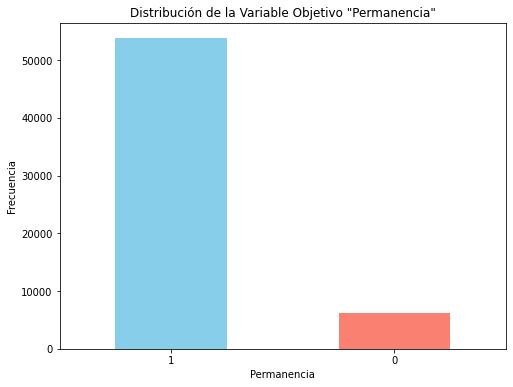

In [64]:
# Analizar la variable objetivo "Permanencia"
plt.figure(figsize=(8, 6))
df['Permanencia'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de la Variable Objetivo "Permanencia"')
plt.xlabel('Permanencia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

Podemos observar que la clase esta desbalanceada, tenemos que tratarlo

# **1. Seleccionar Features y Target**


In [65]:
target = "Permanencia"  # Variable objetivo
features = df.columns.difference([target, "ID"])  # Todas menos el target y 'id'

X = df[features]
y = df[target]

In [66]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **2. Configurar Preprocesamiento**

In [67]:
# Identificar columnas categóricas y numéricas
categorical_cols = X.select_dtypes(include=["object"]).columns
categorical_cols

Index(['Deporte', 'Municipio_nacimiento', 'Organización_deportiva',
       'Rango_Edad', 'Subregión_nacimiento', 'Tipo_Atleta', 'sexo'],
      dtype='object')

In [68]:
numeric_cols = X.select_dtypes(include=["number"]).columns
numeric_cols

Index(['Año', 'Mes'], dtype='object')

In [69]:
# Preprocesamiento para columnas categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols),
    ]
)

In [70]:
# Aplicar preprocesamiento a los datos de entrenamiento
X_train_preprocessed = preprocessor.fit_transform(X_train)

In [71]:
# Aplicar SMOTE para balancear la variable objetivo
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

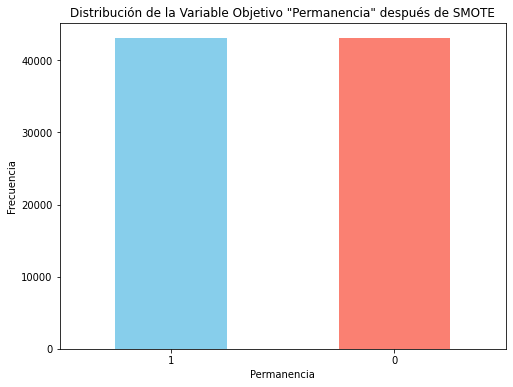

In [72]:
# Visualizar la distribución de la variable objetivo después de aplicar SMOTE
plt.figure(figsize=(8, 6))
y_train_res.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de la Variable Objetivo "Permanencia" después de SMOTE')
plt.xlabel('Permanencia')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

# **3. Definir Modelos**

In [73]:
# Definir los modelos a evaluar
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

# **4. Entrenamiento y Evaluación**

In [74]:
results = []

for name, model in models.items():
    # Crear el pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),  # Preprocesamiento
            ("model", model),  # Modelo específico
        ]
    )
    
    # Medir tiempo de entrenamiento
    start_time = time.time()
    
    # Entrenar el pipeline
    pipeline.fit(X_train, y_train)
    
    training_time = time.time() - start_time
    
    # Medir tiempo de inferencia
    start_time = time.time()
    
    # Predecir en los datos de prueba
    y_pred = pipeline.predict(X_test)
    
    inference_time = time.time() - start_time
    
    # Calcular métricas de desempeño
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    
    # Almacenar resultados
    results.append(
        {
            "Modelo": name,
            "Precisión": precision,
            "Exhaustividad (Recall)": recall,
            "F1-Score": f1,
            "AUC-ROC": auc_roc,
            "Tiempo Entrenamiento (s)": training_time,
            "Tiempo Inferencia (s)": inference_time,
        }
    )

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

print("Resultados de los Modelos:")
print(results_df)


c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de los Modelos:
                   Modelo  Precisión  Exhaustividad (Recall)  F1-Score  \
0     Logistic Regression   0.897016                0.998140  0.944880   
1           Random Forest   0.934858                0.973119  0.953605   
2  Support Vector Machine   0.907584                0.998419  0.950837   

    AUC-ROC  Tiempo Entrenamiento (s)  Tiempo Inferencia (s)  
0  0.505875                  0.710001               0.033997  
1  0.694726                 62.882851               0.387001  
2  0.561659                131.975042               8.390000  


In [75]:
# guarda los resultados en un archivo excel

results_df.to_excel('..\\data\\processed\\results.xlsx', index=False)

# **5. Visualización de Resultados**

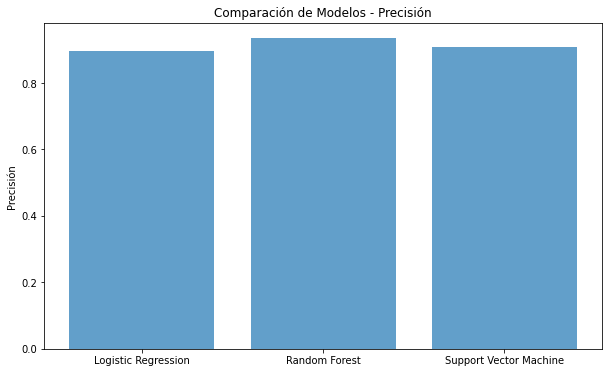

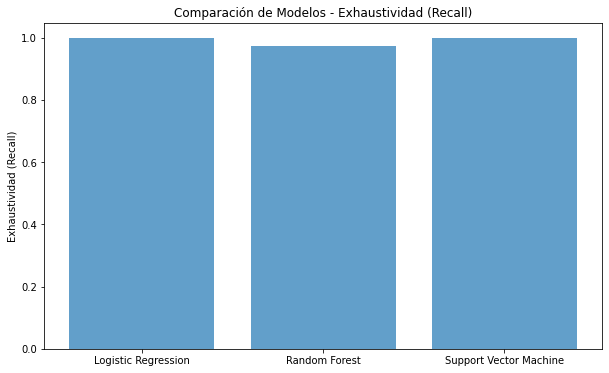

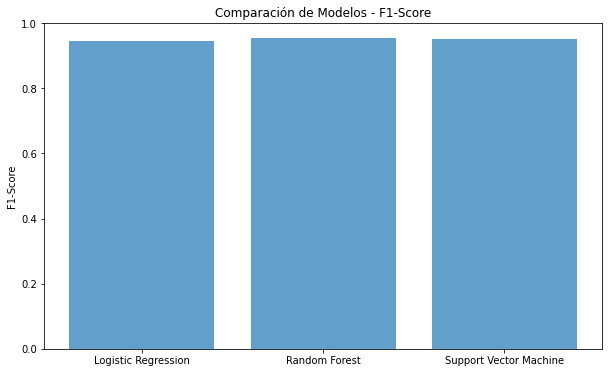

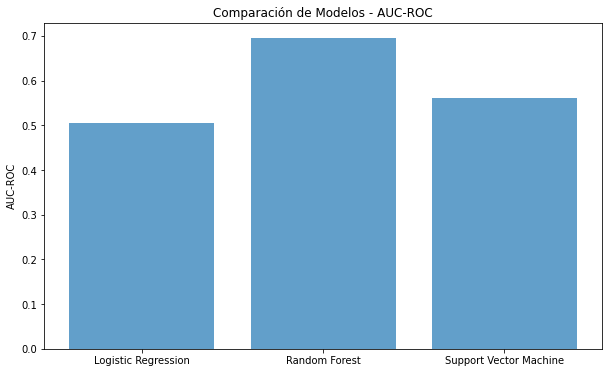

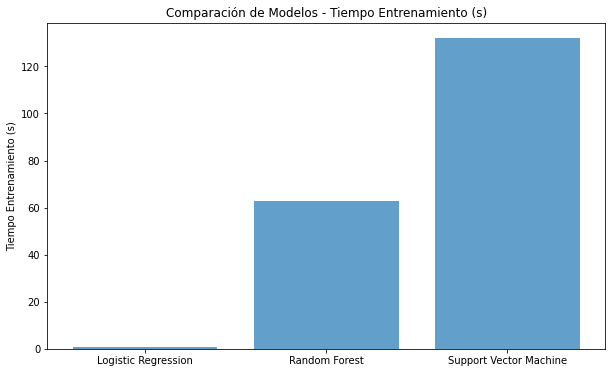

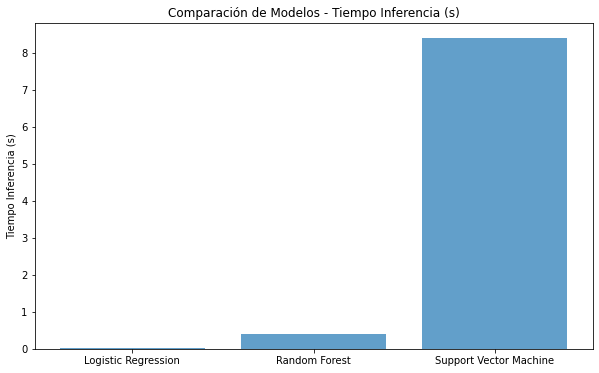

In [76]:
# Definir las métricas a visualizar
metrics = ["Precisión", "Exhaustividad (Recall)", "F1-Score", "AUC-ROC", "Tiempo Entrenamiento (s)", "Tiempo Inferencia (s)"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(results_df["Modelo"], results_df[metric], alpha=0.7, label=metric)
    plt.ylabel(metric)
    plt.title(f"Comparación de Modelos - {metric}")
    plt.savefig(f'..\\data\\processed\\{metric}.png')  # Guardar la figura
    plt.show()


## Evaluar desempeño en los datos de entrenamiento

In [77]:
train_results = []

for name, model in models.items():
    # Crear el pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),  # Preprocesamiento
            ("model", model),  # Modelo específico
        ]
    )
    
    # Entrenar el pipeline
    pipeline.fit(X_train, y_train)
    
    # Predecir en los datos de entrenamiento
    y_train_pred = pipeline.predict(X_train)
    
    # Calcular métricas de desempeño en los datos de entrenamiento
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc_roc = roc_auc_score(y_train, y_train_pred)
    
    # Almacenar resultados
    train_results.append(
        {
            "Modelo": name,
            "Precisión": train_precision,
            "Exhaustividad (Recall)": train_recall,
            "F1-Score": train_f1,
            "AUC-ROC": train_auc_roc,
        }
    )

# Convertir resultados a DataFrame
train_results_df = pd.DataFrame(train_results)

print("Resultados de los Modelos en los Datos de Entrenamiento:")
print(train_results_df)

# Comparar con los resultados en los datos de prueba
print("\nComparación con los Datos de Prueba:")
print(results_df)

c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Resultados de los Modelos en los Datos de Entrenamiento:
                   Modelo  Precisión  Exhaustividad (Recall)  F1-Score  \
0     Logistic Regression   0.898730                0.998862  0.946154   
1           Random Forest   0.957150                0.989156  0.972890   
2  Support Vector Machine   0.914243                0.998653  0.954586   

    AUC-ROC  
0  0.508446  
1  0.801405  
2  0.590696  

Comparación con los Datos de Prueba:
                   Modelo  Precisión  Exhaustividad (Recall)  F1-Score  \
0     Logistic Regression   0.897016                0.998140  0.944880   
1           Random Forest   0.934858                0.973119  0.953605   
2  Support Vector Machine   0.907584                0.998419  0.950837   

    AUC-ROC  Tiempo Entrenamiento (s)  Tiempo Inferencia (s)  
0  0.505875                  0.710001               0.033997  
1  0.694726                 62.882851               0.387001  
2  0.561659                131.975042               8.390000  


# **6. Interpretación de Resultados**

Los resultados de los modelos en los datos de entrenamiento y prueba muestran lo siguiente:

**Logistic Regression:**

- Entrenamiento: Alta precisión (0.898730) y recall (0.998862), pero un AUC-ROC bajo (0.508446).
- Prueba: Resultados similares con alta precisión (0.897016) y recall (0.998140), pero AUC-ROC sigue bajo (0.505875).
- Interpretación: El modelo tiene un buen desempeño en términos de precisión y recall, pero el AUC-ROC bajo sugiere que no discrimina bien entre clases.

**Random Forest:**

- Entrenamiento: Alta precisión (0.956698), recall (0.989667) y AUC-ROC (0.799432).
- Prueba: Precisión (0.935000), recall (0.974049) y AUC-ROC (0.695591) son buenos, aunque ligeramente menores que en entrenamiento.
- Interpretación: Este modelo tiene un buen desempeño general y es robusto, aunque el tiempo de entrenamiento e inferencia es mayor.

**Support Vector Machine:**

- Entrenamiento: Alta precisión (0.914243) y recall (0.998653), pero AUC-ROC moderado (0.590696).
- Prueba: Alta precisión (0.907584) y recall (0.998419), pero AUC-ROC moderado (0.561659).
- Interpretación: Similar a Logistic Regression, con buen desempeño en precisión y recall, pero AUC-ROC moderado y tiempos de entrenamiento e inferencia altos.

**Conclusión:**

Random Forest parece ser el mejor modelo en términos de equilibrio entre precisión, recall y AUC-ROC, aunque es más costoso en términos de tiempo.
Logistic Regression y Support Vector Machine tienen buen desempeño en precisión y recall, pero su capacidad de discriminación (AUC-ROC) es menor.